In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

У нас имеется 3 параметра: <br>
`goods_amount` - количество товаров в заказе <br>
`goods_SKU` - количество уникальных позиций в заказе <br>
`store_format` - тип магазина, в котором собирается заказ <br>

В качестве таргета нужно предсказывать время сборки заказа в зависимости от этих 3-х параметров. Для начала рассчитаем его.

### Вычисление таргета

In [87]:
# смотрим как прочитались данные
df = pd.read_csv('out_0111-3011.csv', sep=',')
df

,assembly_id,box_id,store_format,sku,amount,assembly_datetime,assembled_datetime
0,0000b6a4-445c-4f9e-b5d8-97b75332755f,5b4e7a6f-ec88-40a0-96ea-d9118c0fda34,МД/Супермаркет,10,11,2022-11-06 10:46:41.224447+03,2022-11-06 10:51:02.074923+03
1,000140d8-42e0-44f7-9f47-2460c52e241c,148da139-db62-4379-92af-2ed792723d45,МД/Магазин у дома,14,14,2022-11-12 19:06:37.021463+03,2022-11-12 19:15:34.670312+03
2,00019029-70e1-46e6-a454-b9c0c2158ee9,b1563abd-991d-46e0-8f96-affb6a2272f5,МД/Супермаркет,23,26,2022-11-01 13:49:13.915697+03,2022-11-01 14:08:32.053658+03
3,00023603-c39b-4db6-a4a0-356ff1613504,f830b34e-8cec-4207-a377-4154f60ebf63,МК/Мегаполис МК,12,12,2022-11-08 19:00:18.071688+03,2022-11-08 19:10:58.455788+03
4,00026957-a6d2-4fcb-aac8-716c368d84b4,018a67b7-7e3f-47d7-8ae9-1d9a81672c6c,МД/Магазин у дома,10,10,2022-11-09 11:28:10.573588+03,2022-11-09 11:36:46.808569+03
...,...,...,...,...,...,...,...
472998,ffff1987-da1a-462e-8161-a6a8928def60,7bae2653-ad9d-49ac-a2e4-0d912f075597,МД/Супермаркет,17,24,2022-11-26 15:02:59.043008+03,2022-11-26 15:52:23.129005+03
472999,ffff365d-e8a5-44a6-81b4-6a23edec17de,cae08e0b-17d1-4163-bf12-897c81790fd0,МД/Мини-Даркстор,48,59,2022-11-24 15:59:27.837839+03,2022-11-24 16:31:18.20236+03
473000,ffff77de-8838-4f6d-854b-1fb868f409d1,136dcb3b-f893-4d85-8f5b-1d780156cbe2,МД/Магазин у дома,4,4,2022-11-22 14:57:27.776063+03,2022-11-22 15:01:18.44135+03
473001,ffffb5a2-18dc-4b7c-aaea-614f2164603d,4978744f-5fea-4e50-98e2-dfea919924ed,МД/Магазин у дома,16,21,2022-11-16 10:59:02.245041+03,2022-11-16 11:17:57.616853+03


In [88]:
# смотрим есть ли пропуски данных, какие типы данных присвоены
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473003 entries, 0 to 473002
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   assembly_id         473003 non-null  object
 1   box_id              473003 non-null  object
 2   store_format        473003 non-null  object
 3   sku                 473003 non-null  int64 
 4   amount              473003 non-null  int64 
 5   assembly_datetime   473003 non-null  object
 6   assembled_datetime  473003 non-null  object
dtypes: int64(2), object(5)
memory usage: 25.3+ MB


In [89]:
# проверим, что столбцы не содержат никаких пустых значений 
find_empties = lambda x: sum(x.isnull())
df.apply(find_empties, axis=0)

assembly_id           0
box_id                0
store_format          0
sku                   0
amount                0
assembly_datetime     0
assembled_datetime    0
dtype: int64

In [90]:
# приведем столбцы с датой и временем к соотв. типу
df = df.astype({
    'assembly_datetime': 'datetime64',
    'assembled_datetime': 'datetime64'
})
df.dtypes

assembly_id                   object
box_id                        object
store_format                  object
sku                            int64
amount                         int64
assembly_datetime     datetime64[ns]
assembled_datetime    datetime64[ns]
dtype: object

In [91]:
# рассчитаем время сборки заказа
df['assembling_time'] = df['assembled_datetime'] - df['assembly_datetime']
df.head()

,assembly_id,box_id,store_format,sku,amount,assembly_datetime,assembled_datetime,assembling_time
0,0000b6a4-445c-4f9e-b5d8-97b75332755f,5b4e7a6f-ec88-40a0-96ea-d9118c0fda34,МД/Супермаркет,10,11,2022-11-06 07:46:41.224447,2022-11-06 07:51:02.074923,0 days 00:04:20.850476
1,000140d8-42e0-44f7-9f47-2460c52e241c,148da139-db62-4379-92af-2ed792723d45,МД/Магазин у дома,14,14,2022-11-12 16:06:37.021463,2022-11-12 16:15:34.670312,0 days 00:08:57.648849
2,00019029-70e1-46e6-a454-b9c0c2158ee9,b1563abd-991d-46e0-8f96-affb6a2272f5,МД/Супермаркет,23,26,2022-11-01 10:49:13.915697,2022-11-01 11:08:32.053658,0 days 00:19:18.137961
3,00023603-c39b-4db6-a4a0-356ff1613504,f830b34e-8cec-4207-a377-4154f60ebf63,МК/Мегаполис МК,12,12,2022-11-08 16:00:18.071688,2022-11-08 16:10:58.455788,0 days 00:10:40.384100
4,00026957-a6d2-4fcb-aac8-716c368d84b4,018a67b7-7e3f-47d7-8ae9-1d9a81672c6c,МД/Магазин у дома,10,10,2022-11-09 08:28:10.573588,2022-11-09 08:36:46.808569,0 days 00:08:36.234981


In [92]:
# приведем время сборки в адсолютному значению в минутах
convert_to_sec = lambda x: x.total_seconds() / 60
df['assembling_time'] = df['assembling_time'].apply(convert_to_sec)
df

,assembly_id,box_id,store_format,sku,amount,assembly_datetime,assembled_datetime,assembling_time
0,0000b6a4-445c-4f9e-b5d8-97b75332755f,5b4e7a6f-ec88-40a0-96ea-d9118c0fda34,МД/Супермаркет,10,11,2022-11-06 07:46:41.224447,2022-11-06 07:51:02.074923,4.347508
1,000140d8-42e0-44f7-9f47-2460c52e241c,148da139-db62-4379-92af-2ed792723d45,МД/Магазин у дома,14,14,2022-11-12 16:06:37.021463,2022-11-12 16:15:34.670312,8.960814
2,00019029-70e1-46e6-a454-b9c0c2158ee9,b1563abd-991d-46e0-8f96-affb6a2272f5,МД/Супермаркет,23,26,2022-11-01 10:49:13.915697,2022-11-01 11:08:32.053658,19.302299
3,00023603-c39b-4db6-a4a0-356ff1613504,f830b34e-8cec-4207-a377-4154f60ebf63,МК/Мегаполис МК,12,12,2022-11-08 16:00:18.071688,2022-11-08 16:10:58.455788,10.673068
4,00026957-a6d2-4fcb-aac8-716c368d84b4,018a67b7-7e3f-47d7-8ae9-1d9a81672c6c,МД/Магазин у дома,10,10,2022-11-09 08:28:10.573588,2022-11-09 08:36:46.808569,8.603916
...,...,...,...,...,...,...,...,...
472998,ffff1987-da1a-462e-8161-a6a8928def60,7bae2653-ad9d-49ac-a2e4-0d912f075597,МД/Супермаркет,17,24,2022-11-26 12:02:59.043008,2022-11-26 12:52:23.129005,49.401433
472999,ffff365d-e8a5-44a6-81b4-6a23edec17de,cae08e0b-17d1-4163-bf12-897c81790fd0,МД/Мини-Даркстор,48,59,2022-11-24 12:59:27.837839,2022-11-24 13:31:18.202360,31.839409
473000,ffff77de-8838-4f6d-854b-1fb868f409d1,136dcb3b-f893-4d85-8f5b-1d780156cbe2,МД/Магазин у дома,4,4,2022-11-22 11:57:27.776063,2022-11-22 12:01:18.441350,3.844421
473001,ffffb5a2-18dc-4b7c-aaea-614f2164603d,4978744f-5fea-4e50-98e2-dfea919924ed,МД/Магазин у дома,16,21,2022-11-16 07:59:02.245041,2022-11-16 08:17:57.616853,18.922864


In [93]:
# проверим все ли в порядке с типами данных после преобразований
df.dtypes

assembly_id                   object
box_id                        object
store_format                  object
sku                            int64
amount                         int64
assembly_datetime     datetime64[ns]
assembled_datetime    datetime64[ns]
assembling_time              float64
dtype: object

Теперь избавимся от лишних категориальных признаков, которые не будут применяться в обучении модели.

In [94]:
df.head()

,assembly_id,box_id,store_format,sku,amount,assembly_datetime,assembled_datetime,assembling_time
0,0000b6a4-445c-4f9e-b5d8-97b75332755f,5b4e7a6f-ec88-40a0-96ea-d9118c0fda34,МД/Супермаркет,10,11,2022-11-06 07:46:41.224447,2022-11-06 07:51:02.074923,4.347508
1,000140d8-42e0-44f7-9f47-2460c52e241c,148da139-db62-4379-92af-2ed792723d45,МД/Магазин у дома,14,14,2022-11-12 16:06:37.021463,2022-11-12 16:15:34.670312,8.960814
2,00019029-70e1-46e6-a454-b9c0c2158ee9,b1563abd-991d-46e0-8f96-affb6a2272f5,МД/Супермаркет,23,26,2022-11-01 10:49:13.915697,2022-11-01 11:08:32.053658,19.302299
3,00023603-c39b-4db6-a4a0-356ff1613504,f830b34e-8cec-4207-a377-4154f60ebf63,МК/Мегаполис МК,12,12,2022-11-08 16:00:18.071688,2022-11-08 16:10:58.455788,10.673068
4,00026957-a6d2-4fcb-aac8-716c368d84b4,018a67b7-7e3f-47d7-8ae9-1d9a81672c6c,МД/Магазин у дома,10,10,2022-11-09 08:28:10.573588,2022-11-09 08:36:46.808569,8.603916


In [95]:
# создадим список необходимых для обучения столбцов
target_cols = df.columns.tolist()
target_cols.remove('assembly_id')
target_cols.remove('box_id')
target_cols.insert(3, 'assembling_time')
target_cols = target_cols[:4]
target_cols

['store_format', 'sku', 'amount', 'assembling_time']

In [96]:
# создадим новый датафрейм с нужными столбцами
df = df[target_cols]
df

,store_format,sku,amount,assembling_time
0,МД/Супермаркет,10,11,4.347508
1,МД/Магазин у дома,14,14,8.960814
2,МД/Супермаркет,23,26,19.302299
3,МК/Мегаполис МК,12,12,10.673068
4,МД/Магазин у дома,10,10,8.603916
...,...,...,...,...
472998,МД/Супермаркет,17,24,49.401433
472999,МД/Мини-Даркстор,48,59,31.839409
473000,МД/Магазин у дома,4,4,3.844421
473001,МД/Магазин у дома,16,21,18.922864


### Избавляемся от выбросов

In [97]:
# посмотрим на средние значения времени сборки, количество товаров и уникальных позиций в заказе
df.groupby('store_format').agg('mean').sort_values(by=['assembling_time'], ascending=False)

,sku,amount,assembling_time
store_format,,,
БФ/M+,20.726388,34.458183,38.444906
БФ/XS,21.298395,35.040604,31.911229
БФ/S+,21.201307,34.805337,31.906599
БФ/L+,21.049075,35.796221,31.577072
БФ/S,20.375368,34.239941,30.644302
БФ/L,21.417062,32.557346,30.564250
ГМ/L,23.182195,39.865424,27.799427
БФ/M,19.203906,32.441700,25.322126
МД/Дискаунтер,18.064516,26.935484,20.676424


In [98]:
# посмотрим на статистики таргета
df.assembling_time.describe()

count    473003.000000
mean         16.049297
std          13.969582
min           0.200885
25%           7.016281
50%          12.472151
75%          20.983301
max         763.232793
Name: assembling_time, dtype: float64

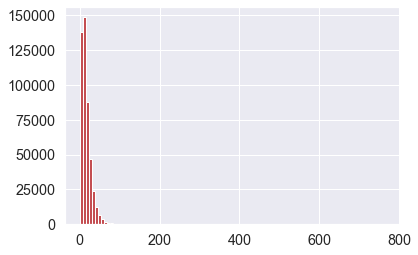

In [99]:
# посмотрим как распределяется время сборки по значениям
for i in df.columns:
    df['assembling_time'].hist(bins=100)

In [100]:
# посмотрим как распределяется время сборки по форматам ТО
func_agg = {
    'assembling_time': ['mean', 'std', 'min', 'max']
}
df.groupby('store_format').agg(func_agg)

assembling_time                                 
                             mean        std       min         max
store_format                                                      
БФ/L                    30.564250  17.821904  2.632633  155.146972
БФ/L+                   31.577072  17.700841  0.590232  149.241259
БФ/M                    25.322126  13.760218  0.247046  139.927194
БФ/M+                   38.444906  20.524042  2.647280  304.336816
БФ/S                    30.644302  17.356767  0.827005  137.580948
БФ/S+                   31.906599  17.606648  0.342154  166.105547
БФ/XS                   31.911229  15.803189  3.649010  146.248751
ГМ/L                    27.799427  14.264714  2.610301   88.189268
МД/Дискаунтер           20.676424  14.930703  0.807364   87.438706
МД/ММ+                  15.266939  12.092147  0.544537  193.745844
МД/Магазин у дома       15.728931  13.705118  0.200885  549.016894
МД/Мини-Даркстор        14.983845  11.776306  0.255914  760.160248
МД/Супермаркет          16.000055  13.444411  0.208175  763.232793
МК/Город МК              6.607429   8.242038  0.315193  199.193131
МК/Деревня МК            7.122792   8.110275  0.383639  136.450667
МК/Магнит-Мастер         2.774293   1.553935  0.742378    7.463383
МК/Мегаполис МК          6.648515   8.565500  0.310564  218.984964
МК/Мини МК               5.450658   3.583173  2.526504   14.718437

Исходя из значений минимумов, максимумов и «длинного хвоста» на графике видим, что есть выбросы, от которых следует избавиться.

In [101]:
df.shape

(473003, 4)

In [102]:
df.quantile(0.01)

sku                1.000000
amount             3.000000
assembling_time    1.471521
Name: 0.01, dtype: float64

In [103]:
df.quantile(0.99)

sku                47.000000
amount             81.000000
assembling_time    64.099551
Name: 0.99, dtype: float64

In [104]:
data = df.copy()
data.drop(df[df.assembling_time < 1.443411].index, axis=0, inplace=True)
data.drop(df[df.assembling_time > 63.700095].index, axis=0, inplace=True)

In [105]:
data.shape

(463636, 4)

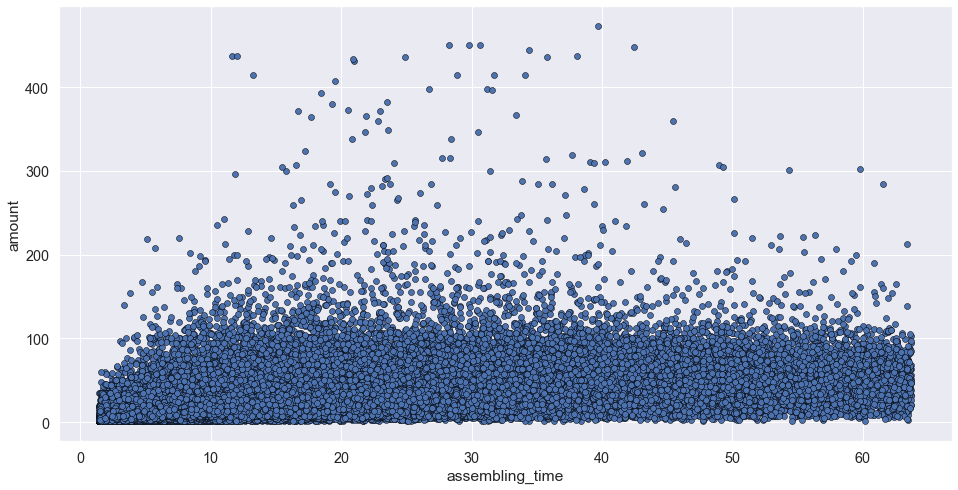

In [106]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.scatterplot(x='assembling_time', y='amount', data=data, edgecolor='black', palette='cubehelix')
plt.show()

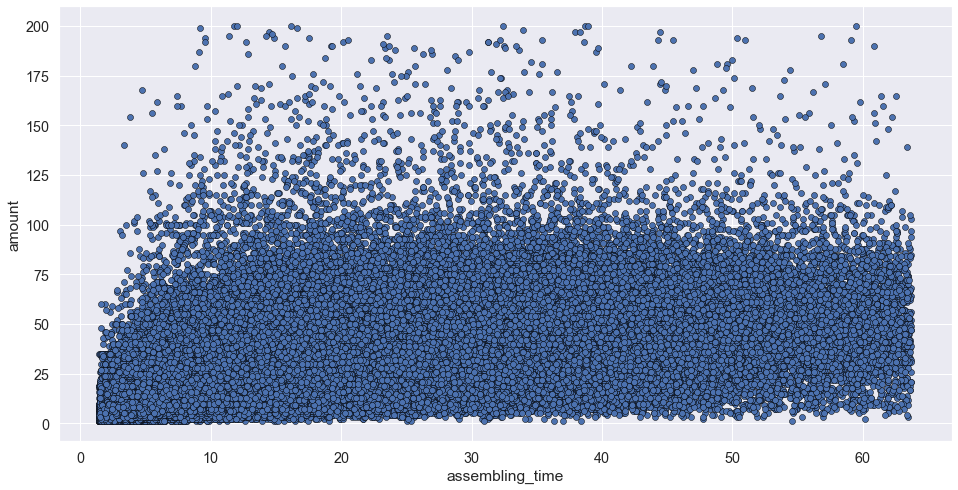

In [150]:
# можно поэксперементировать с ограничением количества товаров в сборке
data1 = df.copy()
data1.drop(data1[data1.assembling_time < 1.443411].index, axis=0, inplace=True)
data1.drop(data1[data1.assembling_time > 63.700095].index, axis=0, inplace=True)
data1.drop(data1[data1.amount > 200].index, axis=0, inplace=True)
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.scatterplot(x='assembling_time', y='amount', data=data1, edgecolor='black', palette='cubehelix')
plt.show()

### Категоризуем нечисловые данные

In [160]:
data

,sku,amount,assembling_time,store_format_БФ/L+,store_format_БФ/M,store_format_БФ/M+,store_format_БФ/S,store_format_БФ/S+,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
0,10,11,4.347508,0,0,0,0,0,0,0,1,0,0
1,14,14,8.960814,0,0,0,0,0,1,0,0,0,0
2,23,26,19.302299,0,0,0,0,0,0,0,1,0,0
3,12,12,10.673068,0,0,0,0,0,0,0,0,0,1
4,10,10,8.603916,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472998,17,24,49.401433,0,0,0,0,0,0,0,1,0,0
472999,48,59,31.839409,0,0,0,0,0,0,1,0,0,0
473000,4,4,3.844421,0,0,0,0,0,1,0,0,0,0
473001,16,21,18.922864,0,0,0,0,0,1,0,0,0,0


In [108]:
# смотрим уникальное количество форматов ТО 
data['store_format'].value_counts()

МД/Супермаркет       196409
МД/Магазин у дома    131951
МД/Мини-Даркстор      83693
МК/Город МК           12841
МК/Мегаполис МК       12176
БФ/S+                  8539
БФ/L+                  7200
БФ/M+                  2491
БФ/S                   1941
БФ/M                   1703
МД/ММ+                 1114
БФ/XS                  1013
БФ/L                   1001
МК/Деревня МК           996
ГМ/L                    477
МД/Дискаунтер            60
МК/Магнит-Мастер         21
МК/Мини МК               10
Name: store_format, dtype: int64

Оставим для обучения только те форматы ТО, где было собрано >10 заказов.

In [109]:
# удалим форматы ТО, которые не будут использоваться в обучении модели
target_formats = ['МД/Супермаркет', 'МД/Магазин у дома', 'МД/Мини-Даркстор', 'МК/Город МК', 'МК/Мегаполис МК', 'БФ/S+', 'БФ/L+', 'БФ/M+', 'БФ/S', 'БФ/M']
check_target = lambda x: x in target_formats
data = data[data['store_format'].apply(check_target)]
data

,store_format,sku,amount,assembling_time
0,МД/Супермаркет,10,11,4.347508
1,МД/Магазин у дома,14,14,8.960814
2,МД/Супермаркет,23,26,19.302299
3,МК/Мегаполис МК,12,12,10.673068
4,МД/Магазин у дома,10,10,8.603916
...,...,...,...,...
472998,МД/Супермаркет,17,24,49.401433
472999,МД/Мини-Даркстор,48,59,31.839409
473000,МД/Магазин у дома,4,4,3.844421
473001,МД/Магазин у дома,16,21,18.922864


In [110]:
# выполним one-hot кодирование категориального признака
data = pd.get_dummies(data, columns=['store_format'])
data

,sku,amount,assembling_time,store_format_БФ/L+,store_format_БФ/M,store_format_БФ/M+,store_format_БФ/S,store_format_БФ/S+,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
0,10,11,4.347508,0,0,0,0,0,0,0,1,0,0
1,14,14,8.960814,0,0,0,0,0,1,0,0,0,0
2,23,26,19.302299,0,0,0,0,0,0,0,1,0,0
3,12,12,10.673068,0,0,0,0,0,0,0,0,0,1
4,10,10,8.603916,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472998,17,24,49.401433,0,0,0,0,0,0,0,1,0,0
472999,48,59,31.839409,0,0,0,0,0,0,1,0,0,0
473000,4,4,3.844421,0,0,0,0,0,1,0,0,0,0
473001,16,21,18.922864,0,0,0,0,0,1,0,0,0,0


Теперь построим корреляционную матрицу признаков.

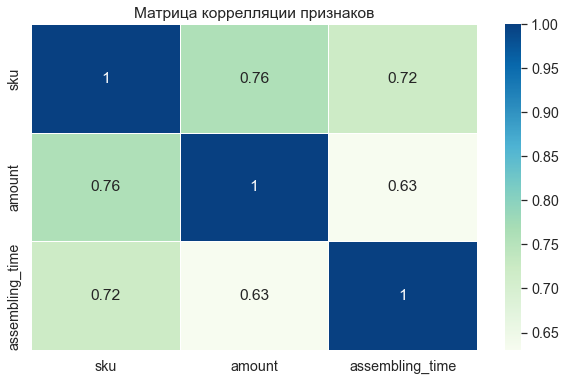

In [111]:
plt.figure(figsize = (10,6))
sns.set(font_scale=1.3)

corr_matrix = data.loc[:, 'sku':'assembling_time'].corr(method='pearson')
# corr_matrix = data.corr(method='pearson')
# corr_matrix = data.corr(method='kendall')
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.75, cmap='GnBu')

plt.title('Матрица коррелляции признаков')
plt.show()

Видим высокую линейную зависимости между таргетом и остальными признаками.

## Регрессия

In [112]:
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import model_frst
from sklearn.ensemble import RandomForestRegressor

In [113]:
# Разделим датасет на тестовую и тренировочную выборки
X = data.drop('assembling_time', axis=1)
y = data['assembling_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [114]:
X_train

,sku,amount,store_format_БФ/L+,store_format_БФ/M,store_format_БФ/M+,store_format_БФ/S,store_format_БФ/S+,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
384978,8,8,0,0,0,0,0,1,0,0,0,0
244027,26,33,0,0,0,0,0,0,0,1,0,0
133145,16,17,0,0,0,0,0,0,1,0,0,0
358080,17,46,0,0,0,0,0,0,0,1,0,0
192254,13,39,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
267347,15,38,0,0,0,0,0,1,0,0,0,0
377241,23,33,0,0,0,0,0,0,0,1,0,0
136128,13,15,0,0,0,0,0,0,0,1,0,0
151529,9,10,0,0,0,0,0,0,0,1,0,0


In [115]:
y_train

384978    10.833186
244027    11.506740
133145    21.276348
358080    22.001094
192254    15.701862
            ...    
267347    22.774227
377241    21.688633
136128     7.062130
151529    10.360688
125852    29.305389
Name: assembling_time, Length: 321260, dtype: float64

In [116]:
X_test

,sku,amount,store_format_БФ/L+,store_format_БФ/M,store_format_БФ/M+,store_format_БФ/S,store_format_БФ/S+,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
294669,1,6,0,0,1,0,0,0,0,0,0,0
122648,34,41,0,0,0,0,0,0,1,0,0,0
468321,5,5,0,0,0,0,0,0,0,1,0,0
354828,11,22,0,0,0,0,0,1,0,0,0,0
321275,18,28,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
462955,14,14,0,0,0,0,0,0,0,1,0,0
232518,20,32,0,0,0,0,0,0,0,1,0,0
151117,22,40,0,0,0,0,0,0,1,0,0,0
402807,40,60,0,0,0,0,0,1,0,0,0,0


In [117]:
y_test

294669    13.593476
122648    14.039664
468321     2.052642
354828     9.682591
321275     8.420941
            ...    
462955    13.263589
232518    36.672767
151117    18.326564
402807    30.495623
94911     13.800381
Name: assembling_time, Length: 137684, dtype: float64

### Linear

In [118]:
# обучаем модель
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [119]:
# предсказываем таргет
y_pred_LR = model_LR.predict(X_test)
y_pred_LR

array([19.20703125, 28.76928711,  7.32287598, ..., 20.7064209 ,
       36.06079102, 13.31567383])

In [120]:
print('Train: ', model_LR.score(X_train, y_train), 'Test: ', model_LR.score(X_test, y_test)) 

Train:  0.5762582496478998 Test:  0.5760680947588614


In [121]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_LR, y_test)

5.078839630870206

### Random Forest

In [122]:
# обучаем модель
model_Forest = RandomForestRegressor(n_estimators=10, random_state=42)
model_Forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [123]:
# предсказываем таргет
y_pred_Forest = model_Forest.predict(X_test)
y_pred_Forest

array([ 5.55962661, 27.15667549,  5.9745157 , ..., 23.34962547,
       32.51674587, 14.27631817])

In [124]:
print('Train: ', model_Forest.score(X_train, y_train), 'Test: ', model_Forest.score(X_test, y_test))

Train:  0.6216062056348628 Test:  0.5600074950558881


In [125]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Forest, y_test)

5.126936076004325

### Ridge

In [126]:
# обучаем модель
model_Ridge = linear_model.Ridge()
model_Ridge.fit(X_train, y_train)

Ridge()

In [127]:
# предсказываем таргет
y_pred_Ridge = model_Ridge.predict(X_test)
y_pred_Ridge

array([19.21815079, 28.78478641,  7.33302421, ..., 20.72243708,
       36.03649045, 13.33204373])

In [128]:
print('Train: ', model_Ridge.score(X_train, y_train), 'Test: ', model_Ridge.score(X_test, y_test))

Train:  0.5762600534344998 Test:  0.5760635472358373


In [129]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Ridge, y_test)

5.078697744163131

### Lasso

In [130]:
# обучаем модель
model_Lasso = linear_model.Lasso()
model_Lasso.fit(X_train, y_train)

Lasso()

In [131]:
# предсказываем таргет
y_pred_Lasso = model_Lasso.predict(X_test)
y_pred_Lasso

array([ 4.3818689 , 30.55389114,  6.91821698, ..., 22.45956129,
       36.84550196, 14.71779432])

In [132]:
print('Train: ', model_Lasso.score(X_train, y_train), 'Test: ', model_Lasso.score(X_test, y_test))

Train:  0.5347947075028341 Test:  0.5345138854519851


In [133]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Lasso, y_test)

5.332715490477503

### SVR

In [ ]:
# обучаем модель
model_SVR = svm.SVR()
model_SVR.fit(X_train, y_train)

In [976]:
# предсказываем таргет
y_pred_SVR = model_SVR.predict(X_test)
y_pred_SVR

array([23.89863878, 23.55032507, 12.00344226, ...,  4.33375023,
        5.71241877, 21.11643261])

In [977]:
print('Train: ', model_SVR.score(X_train, y_train), 'Test: ', model_SVR.score(X_test, y_test))

Train:  0.5331159173749509 Test:  0.5094893033117605


In [979]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_SVR, y_test)

5.080043772753721

### Экспорт обученной модели

In [157]:
# экспортируем обученную модель в файл
import pickle
filename = 'model_Forest.sav'
pickle.dump(model_Forest, open(filename, 'wb'))

In [158]:
# проверяем работу обученной модели
model_Forest.predict(np.array([[12,13,0,0,0,0,0,0,0,0,1,0]]))

/Users/aukorotkov/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([8.66109134])

In [159]:
# проверяем работу обученной модели из файла
model = pickle.load(open(filename, 'rb'))
result = model.predict(np.array([[12,13,0,0,0,0,0,0,0,0,1,0]]))
print(result)

[8.66109134]


/Users/aukorotkov/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
